In [331]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

In [380]:
prices_path = "prices_round_1_day_-1.csv"
prices2_path = "prices_round_1_day_-2.csv"
trades_path = "trades_round_1_day_-1.csv"

In [555]:
prices = pd.read_csv(prices_path, sep = ";", index_col = 1)
prices2 = pd.read_csv(prices2_path, sep = ";", index_col = 1)
prices[prices["product"]=="KELP"].loc[600:1500]
prices[prices["product"]=="SQUID_INK"].loc[600:1500]

,day,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
timestamp,,,,,,,,,,,,,,,,
600,-1,SQUID_INK,2006,5,2005.0,6.0,2004.0,25.0,2008,25,NaN,NaN,NaN,NaN,2007.0,0.0
700,-1,SQUID_INK,2006,2,2005.0,23.0,NaN,NaN,2009,23,NaN,NaN,NaN,NaN,2007.5,0.0
800,-1,SQUID_INK,2005,30,NaN,NaN,NaN,NaN,2008,1,2009.0,29.0,NaN,NaN,2006.5,0.0
900,-1,SQUID_INK,2005,23,NaN,NaN,NaN,NaN,2008,23,NaN,NaN,NaN,NaN,2006.5,0.0
1000,-1,SQUID_INK,2005,26,NaN,NaN,NaN,NaN,2007,6,2009.0,26.0,NaN,NaN,2006.0,0.0
1100,-1,SQUID_INK,2007,6,2006.0,26.0,NaN,NaN,2009,2,2010.0,24.0,NaN,NaN,2008.0,0.0
1200,-1,SQUID_INK,2006,21,NaN,NaN,NaN,NaN,2008,8,2009.0,21.0,NaN,NaN,2007.0,0.0
1300,-1,SQUID_INK,2007,31,NaN,NaN,NaN,NaN,2010,31,NaN,NaN,NaN,NaN,2008.5,0.0
1400,-1,SQUID_INK,2006,28,NaN,NaN,NaN,NaN,2009,26,NaN,NaN,NaN,NaN,2007.5,0.0


In [381]:
trades = pd.read_csv(trades_path, sep = ';', index_col = 0)
trades

,buyer,seller,symbol,currency,price,quantity
timestamp,,,,,,
0,NaN,NaN,KELP,SEASHELLS,2029.0,13
0,NaN,NaN,KELP,SEASHELLS,2029.0,1
0,NaN,NaN,RAINFOREST_RESIN,SEASHELLS,10004.0,1
0,NaN,NaN,SQUID_INK,SEASHELLS,2006.0,13
0,NaN,NaN,SQUID_INK,SEASHELLS,2006.0,1
...,...,...,...,...,...,...
999200,NaN,NaN,SQUID_INK,SEASHELLS,1970.0,1
999400,NaN,NaN,SQUID_INK,SEASHELLS,1971.0,1
999500,NaN,NaN,KELP,SEASHELLS,2030.0,2


In [556]:
squid_ink = prices[prices["product"] == "SQUID_INK"]
kelp = prices[prices["product"] == "KELP"]
rainforest_resin = prices[prices["product"] == "RAINFOREST_RESIN"]
squid_ink2 = prices2[prices2["product"] == "SQUID_INK"]

In [135]:
def calculate_row_vwap(prices):
    """
    Calculate VWAP for each row using all available bid and ask levels.
    Handles DataFrames with duplicate indices.
    """
    prices = prices.copy()
    
    # Create columns to store the price*volume and volume for each level
    prices['total_pv'] = 0
    prices['total_volume'] = 0
    
    # Process bid levels
    for i in range(1, 4):  # Assuming 3 levels of depth
        price_col = f'bid_price_{i}'
        vol_col = f'bid_volume_{i}'
        
        if price_col in prices.columns and vol_col in prices.columns:
            # For each level, calculate price*volume where both values exist
            mask = (~prices[price_col].isna()) & (~prices[vol_col].isna())
            pv_col = f'pv_bid_{i}'
            prices[pv_col] = prices[price_col] * prices[vol_col] * mask
            
            # Add to running totals
            prices['total_pv'] += prices[pv_col].fillna(0)
            prices['total_volume'] += prices[vol_col].fillna(0) * mask
            
            # Clean up temporary column
            prices.drop(pv_col, axis=1, inplace=True)
    
    # Process ask levels
    for i in range(1, 4):
        price_col = f'ask_price_{i}'
        vol_col = f'ask_volume_{i}'
        
        if price_col in prices.columns and vol_col in prices.columns:
            # For each level, calculate price*volume where both values exist
            mask = (~prices[price_col].isna()) & (~prices[vol_col].isna())
            pv_col = f'pv_ask_{i}'
            prices[pv_col] = prices[price_col] * prices[vol_col] * mask
            
            # Add to running totals
            prices['total_pv'] += prices[pv_col].fillna(0)
            prices['total_volume'] += prices[vol_col].fillna(0) * mask
            
            # Clean up temporary column
            prices.drop(pv_col, axis=1, inplace=True)
    
    # Calculate VWAP
    prices['price'] = prices['total_pv'] / prices['total_volume'].replace(0, float('nan'))
    
    # If any rows have zero total volume, fallback to mid_price
    if 'mid_price' in prices.columns:
        prices['price'] = prices['price'].fillna(prices['mid_price'])
    
    # Clean up the intermediate columns
    prices.drop(['total_pv', 'total_volume'], axis=1, inplace=True)
    
    return prices

In [519]:
prices2 = calculate_row_vwap(prices2)

In [558]:
squid_prices = squid_ink["mid_price"]
kelp_prices = kelp["mid_price"]
resin_prices = rainforest_resin["mid_price"]
norm_squid = (squid_prices - squid_prices.mean())/squid_prices.std()
norm_kelp = (kelp_prices - squid_prices.mean())/kelp_prices.std()

squid_prices2 = squid_ink2["mid_price"]

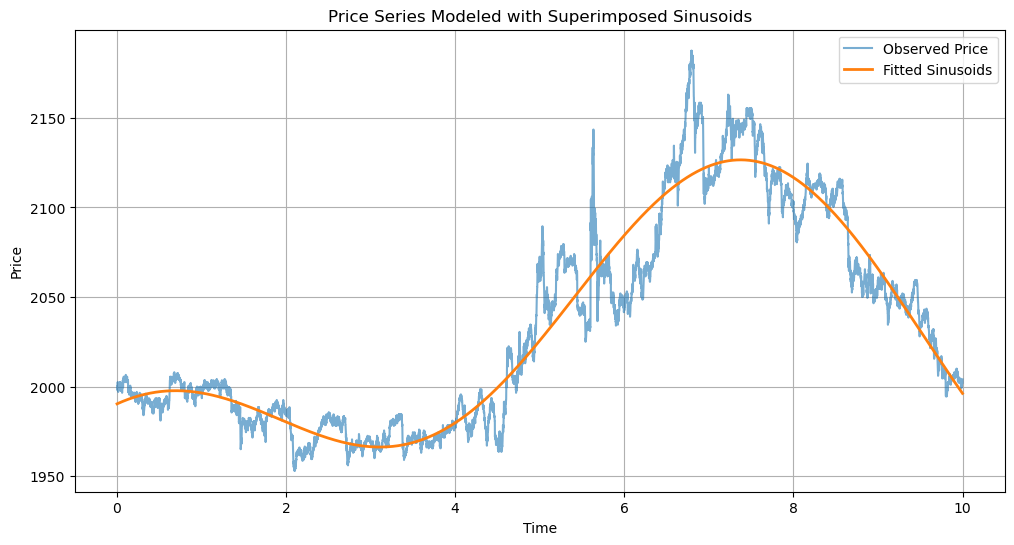

In [560]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example: generate synthetic price data (you can replace this with your own)
np.random.seed(42)
t = np.linspace(0, 10, 10000)  # 10 seconds sampled 1000 times

# === Model: Sum of sinusoids ===
def superimposed_sinusoids(t, *params):
    """Sum of N sinusoids: [A1, f1, phi1, A2, f2, phi2, ...]"""
    n = len(params) // 3
    result = np.zeros_like(t)
    for i in range(n):
        A = params[3*i]
        f = params[3*i + 1]
        phi = params[3*i + 2]
        result += A * np.sin(2 * np.pi * f * t + phi)
    return result

# === Initial guess: [A1, f1, phi1, A2, f2, phi2, ...] ===
# Feel free to adjust the number of sinusoids or guesses
initial_guess = [2, 0.05, 0, 1.5, 0.15, 1]

price_series = squid_prices2.copy(deep = True)
# Fit the model to the price data
popt, _ = curve_fit(superimposed_sinusoids, t, price_series - 2000, p0=initial_guess)

# Reconstruct the fitted wave
fitted_wave = superimposed_sinusoids(t, *popt) + +2000

# === Plot the result ===
plt.figure(figsize=(12, 6))
plt.plot(t, price_series, label='Observed Price', alpha=0.6)
plt.plot(t, fitted_wave, label='Fitted Sinusoids', linewidth=2)
plt.title('Price Series Modeled with Superimposed Sinusoids')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [561]:
print(popt, run1_params)

[ 7.36530655e+01 -6.13436729e-02 -8.36930553e+00  5.50930710e+01
  1.36158679e-01  1.41481635e+00] [-31.64266856   0.16602985  -1.14593185 -20.4205408    0.27437956
   0.33184561]


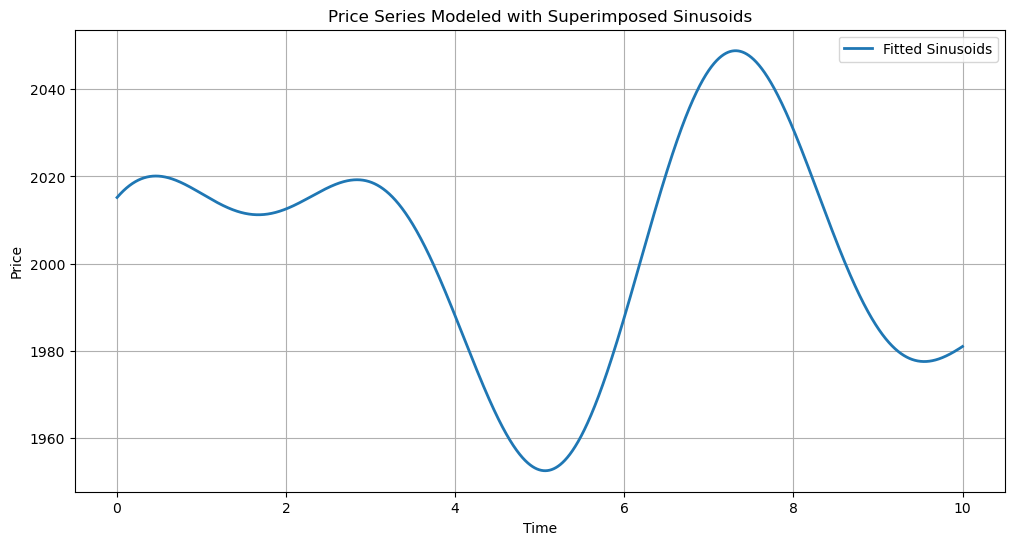

In [544]:
t_extension = np.linspace(t[-1], t[-1] + 10, 10000)  # 5 units after last timestamp

# === Generate sinusoid prediction on extension ===
fitted_continuation = superimposed_sinusoids(t_extension, *popt) + 2000
#run1_params
plt.figure(figsize=(12, 6))
#plt.plot(t, price_series, label='Observed Price', alpha=0.6)
plt.plot(t, fitted_continuation, label='Fitted Sinusoids', linewidth=2)
plt.title('Price Series Modeled with Superimposed Sinusoids')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [534]:
fitted_params = popt
fitted_params

array([-26.2985178 ,  -0.18563637,   5.22172523,  18.51532728,
         0.30142843,   8.92373104])

In [515]:
k = kelp_prices.shift(500).dropna()
s = squid_prices[squid_prices.index.isin(k.index)]
print(coint(s,k))
print(norm_kelp.corr(norm_squid.shift(500)))

(-3.0205919886793713, 0.10539156357000307, array([-3.89759332, -3.33677331, -3.04489652]))
-0.2684612678618343


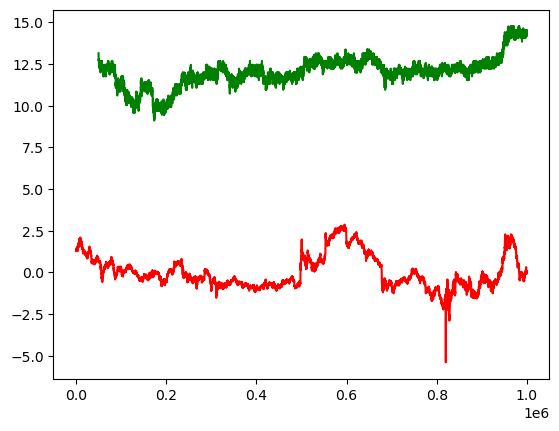

In [516]:
plt.plot(norm_squid, color = "red")
plt.plot(norm_kelp.shift(500), color = "green")
#plt.plot(norm_squid-norm_kelp)

In [300]:
lookback = 10

up_up = 0
up_down = 0
down_up = 0
down_down = 0

for i, price in enumerate(squid_prices.iloc[lookback:-2]):
    if(price > squid_prices.iloc[i]):
        if(price < squid_prices.iloc[i+lookback+1]):
            up_up +=1
        elif(price > squid_prices.iloc[i+lookback+1]):
            up_down +=1
    else:
        if(price < squid_prices.iloc[i+lookback+1]):
            down_up +=1
        elif(price > squid_prices.iloc[i+lookback+1]):
            down_down +=1
    

In [365]:
lookback =10
y = np.array(squid_prices[lookback-1:])
X = np.array(resin_prices.rolling(lookback).std().dropna()).astype(float).reshape(-1, 1)  # make it 2D
X = sm.add_constant(X)  # adds intercept

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.17
Date:                Mon, 07 Apr 2025   Prob (F-statistic):            0.00144
Time:                        18:14:13   Log-Likelihood:                -46655.
No. Observations:                9991   AIC:                         9.331e+04
Df Residuals:                    9989   BIC:                         9.333e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1968.7767      0.898   2193.277      0.0

In [301]:
print(up_up, up_down, down_up, down_down)

1914 2096 2283 1967


In [421]:
matching_rows = {}

prod1 = "KELP"
prod2 = "SQUID_INK"
min_quantity =5


for timestamp, group in trades.groupby('timestamp'):

    sub = group[group['symbol'].isin([prod1, prod2])]

    a_rows = sub[sub['symbol'] == prod1]
    b_rows = sub[sub['symbol'] == prod2]

    for _, row_a in a_rows.iterrows():
        for _, row_b in b_rows.iterrows():
            if row_a['quantity'] == row_b['quantity'] and row_a['quantity'] >= min_quantity:
                if(timestamp not in matching_rows):
                    matching_rows[timestamp] = []
                matching_rows[timestamp].append(row_a)
                matching_rows[timestamp].append(row_b)


In [422]:
matching_buys = 0
matching_sells = 0
opposite = 0

directions = {}

for timestamp, matches in matching_rows.items():
    prod1 = matches[0]
    prod2 = matches[1]
    if timestamp == 0:
        continue
    
    sell = 0
    
    for prod in [prod1, prod2]:
        bids = ["bid_price_1", "bid_price_2", "bid_price_3"]
        if any(prices[prices["product"] == prod.loc["symbol"]].loc[timestamp, bid] == prod.loc["price"] for bid in bids):
            if(prod.loc["symbol"] not in directions):
                directions[prod.loc["symbol"]] = []
            directions[prod.loc["symbol"]].append([timestamp, prod, "sell"])   
            sell += 1  
        else:
            if(prod.loc["symbol"] not in directions):
                directions[prod.loc["symbol"]] = []
            directions[prod.loc["symbol"]].append([timestamp, prod, "buy"])   
    if(sell == 2):
        matching_sells += 1
    elif(sell == 0):
        matching_buys += 1
    else:
        opposite += 1

In [423]:
print(matching_buys, matching_sells, opposite)

215 217 25


In [424]:
look_ahead = 30
add = 0
count = 0
# Filter for just SQUID_INK prices
squid_prices = prices[prices["product"] == "SQUID_INK"].sort_index()

for ts, trade_row, direction in directions["SQUID_INK"]:
    if direction == "sell":
        continue  # Only care about buys

    if ts not in squid_prices.index:
        continue  # skip if timestamp isn't in price data
    count += 1
    try:
        current_idx = squid_prices.index.get_loc(ts)
        future_idx = current_idx + look_ahead
        
        if future_idx >= len(squid_prices):
            continue  # skip if lookahead goes out of bounds

        current_price = squid_prices.iloc[current_idx]["price"]
        future_price = squid_prices.iloc[future_idx]["price"]

        if future_price > current_price:
            add += 1
    except KeyError:
        continue  # skip if timestamp not found or any other issue

print(f"{add} buy trades were followed by a price increase in {look_ahead} ticks.")


112 buy trades were followed by a price increase in 30 ticks.


In [425]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_trade_directions(prices, directions, start_time=None, end_time=None):
    # Ensure timestamp is datetime and sort
    prices = prices.copy()
    products = list(directions.keys())
    
    # Filter prices based on the start_time and end_time
    if start_time:
        prices = prices[prices.index >= start_time]
    if end_time:
        prices = prices[prices.index <= end_time]
    
    # Create a single figure for both products
    plt.figure(figsize=(14, 8))
    
    # Define colors for each product
    colors = {products[0]: 'black', products[1]: 'blue'}
    
    # Plot both product price lines
    for product in products:
        product_prices = prices[prices['product'] == product]
        plt.plot(product_prices.index, product_prices['price'], 
                 label=f'{product} Price', color=colors.get(product, 'gray'))
    
    # Plot trades for both products
    buy_plotted = sell_plotted = False
    for product in products:
        for entry in directions[product]:
            ts, row, direction = entry
            
            # Skip if timestamp is not in the filtered price data
            if ts not in prices.index:
                continue
                
            # Find price at timestamp
            price = row['price'] if 'price' in row else prices[(prices.index == ts) & 
                                                               (prices['product'] == product)]['price'].values[0]
            
            marker_size = 100
            if direction == 'buy':
                label = 'Buy' if not buy_plotted else ""
                buy_plotted = True
                plt.scatter(ts, price, color='green', marker='^', s=marker_size, label=label)
            elif direction == 'sell':
                label = 'Sell' if not sell_plotted else ""
                sell_plotted = True
                plt.scatter(ts, price, color='red', marker='v', s=marker_size, label=label)
            else:
                label = 'Other' if ts == directions[product][0][0] else ""
                plt.scatter(ts, price, color='blue', marker='o', s=marker_size, label=label)
    
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.title(f'Price Chart with Trade Directions for {" & ".join(products)}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


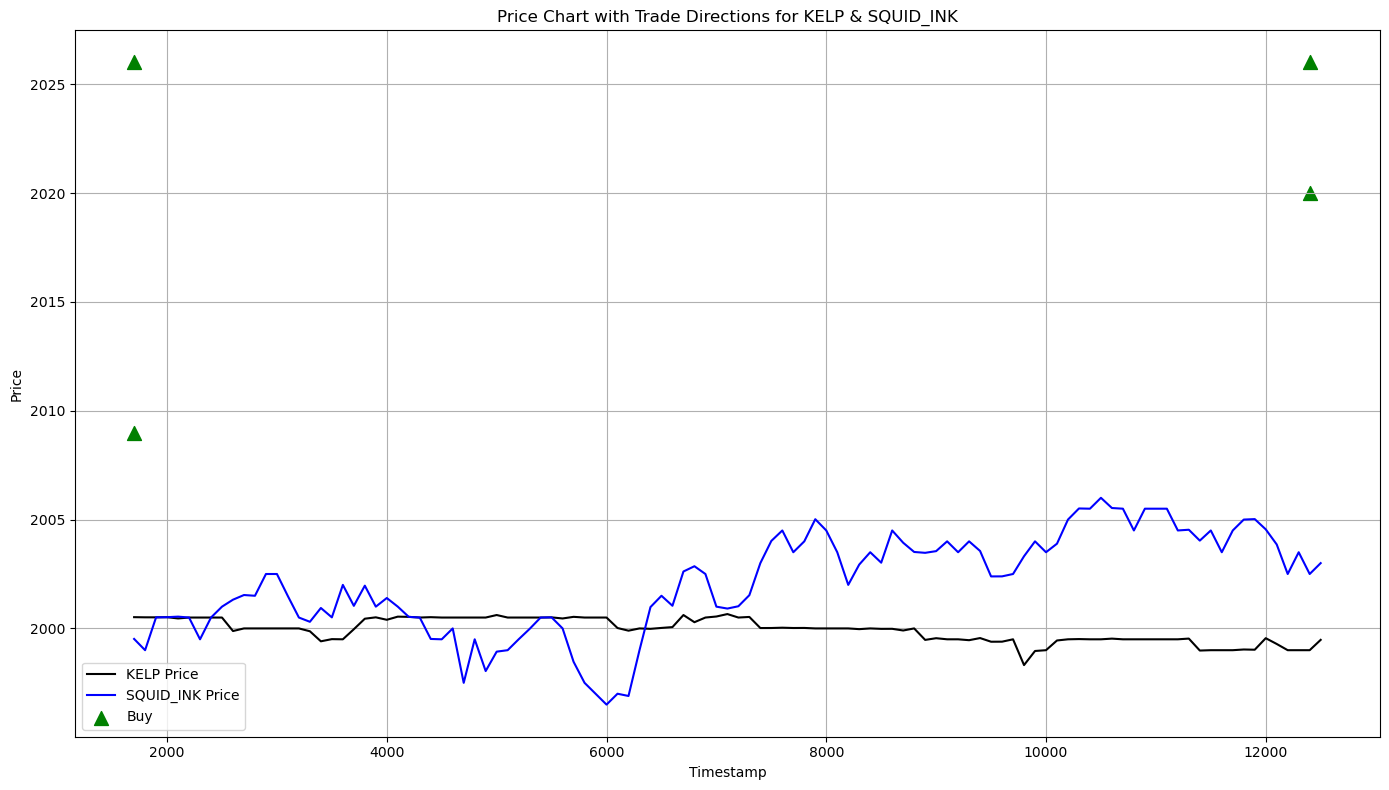

In [521]:
plot_trade_directions(prices2, directions, 12400, )

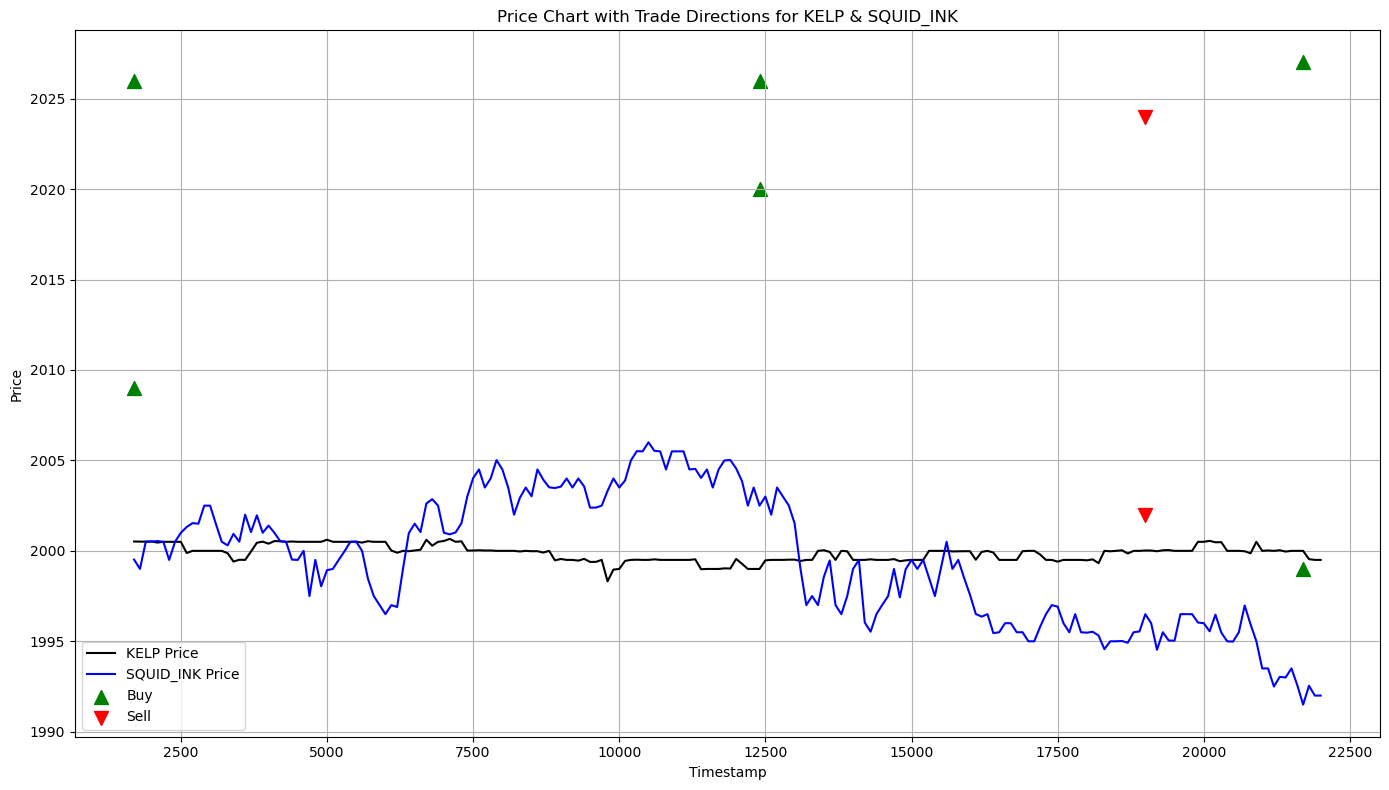

In [526]:
plot_trade_directions(prices2, directions, 1700, 22000)

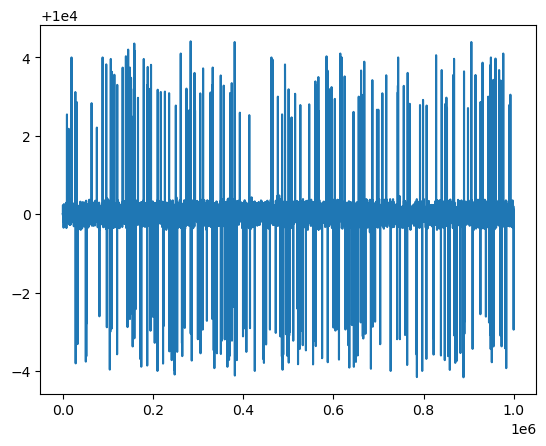

In [427]:
print(kelp_prices.corr(squid_prices))

ValueError: operands could not be broadcast together with shapes (10000,) (10000,17) 

In [242]:
put = generate_trading_strategy_recommendations(analyze_price_patterns(prices, product_column='product', price_column='price', timestamp_column=None))

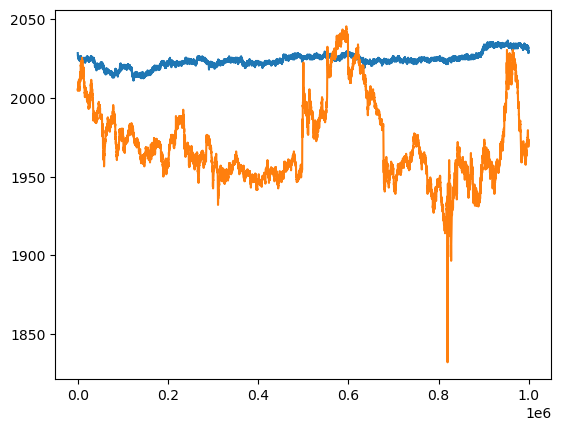

In [527]:
plt.plot(kelp_prices)
plt.plot(squid_prices)